## Задача на собственные частоты голосового тракта

$$\frac{d}{dx}(S(x)\frac{d}{dx}\Psi(x)) + \lambda S(x)\Psi(x) = 0, 0 < x < L$$

$$\Psi'(0) = 0, 8\sqrt{S(L)}\Psi'(L) + 3\pi\sqrt{\pi}\Psi(L) = 0$$

$S(x)$ - площадь сечения голосового тракта

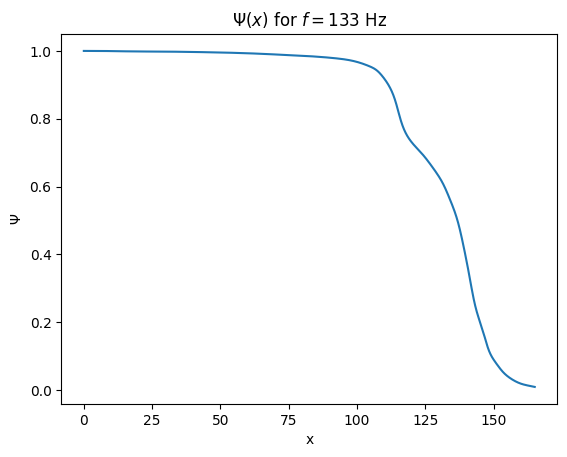

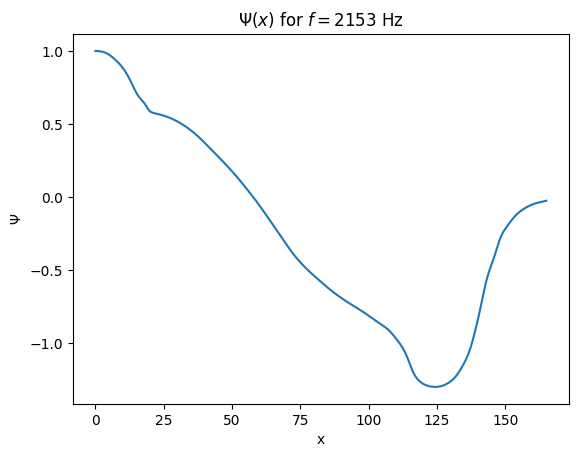

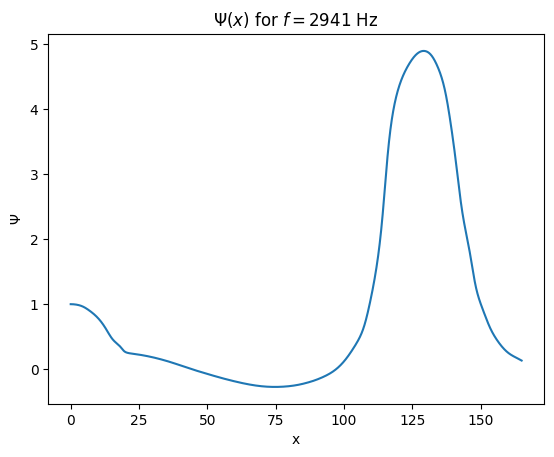

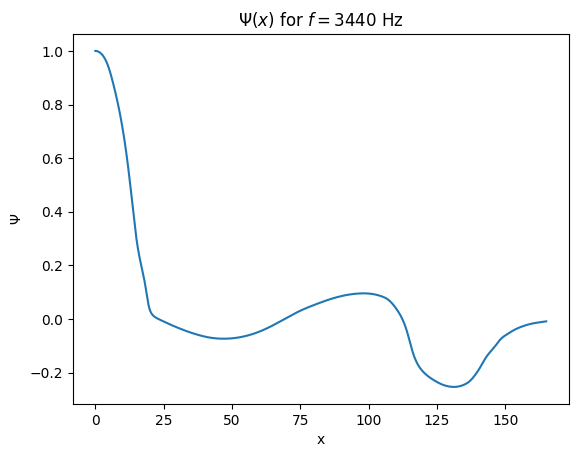

In [1]:
from BVPlib import *
from math import *
import matplotlib.pyplot as plt
from splinelib import NaturalSpline

RtoR = Callable[[float], float]
R2toR = Callable[[float, float], float]

def diff(f : RtoR, x : float):
    return (f(x + Differetiator.step) - f(x - Differetiator.step)) / (2 * Differetiator.step)

class SLPSolver:
    eps = 1e-4
    step = 1e-7

    # (S(x)y')' + lb*S(x)y = 0
    # y'(0) = 0, R(y, y') = 0
    # returns lb, y(x)
    @staticmethod
    def solve_by_shooting_method(S : RtoR, R : R2toR, N: int, L : float, initial_value : float):
        lb = initial_value
        h = L/N
        def M(l : float):
            f : VecTFunc = lambda x, q: Vector(q[1], -l * q[0] - diff(S, x)/S(x) * q[1])
            fL = RungeKuttaMethods.explicit_4_order(f, Vector(1, 0), h, N, 0)[N]
            return R(fL[0], fL[1])
        while(True):
            ODEIOSettings.info("lb = " + str(lb))
            boundary = M(lb)
            if(abs(boundary) < SLPSolver.eps):
                break
            lb = lb - boundary / diff(M, lb)
        f : VecTFunc = lambda x, q: Vector(q[1], -lb * q[0] - diff(S, x)/S(x) * q[1])
        return lb, RungeKuttaMethods.explicit_4_order(f, Vector(1, 0), h, N, 0)
    
def show_result(N : int, solution : tuple[float, list[Vector]], L : float):
    lb, us = solution
    h = L/N
    xs = [h*k for k in range(N + 1)]
    plt.plot(xs, [us[k][0] for k in range(N + 1)])
    plt.xlabel("x")
    plt.ylabel("$\\Psi$")
    plt.title(f"$\\Psi(x)$ for $f={int(sqrt(lb) * 331e3 / 2 / pi)}$ Hz")
    plt.show()

S = NaturalSpline([2.5*k for k in range(67)], 
    [78.2, 66.4, 43, 39.1, 33.2, 25.4, 31.3, 50.8, 87.7, 444, 523.2, 532.2, 538.5, 531.7, 527.2, 504.5, 498.7, 527,
    570.6, 572.5, 566.7, 549.1, 535.4, 515.9, 486.6, 453.3, 434.8, 420, 420.7, 437.2, 470.5, 480.8, 457.2, 408.4, 361.5,
    340, 295.5, 257.9, 203.2, 144.6, 103.6, 80.1, 64.5, 33.2, 21.5, 13.7, 7.8, 13.7, 23.4, 27.4, 23.4, 21.2, 18.5,
    13, 11.3, 7.2, 5.8, 5.9, 9.8, 9, 19.5, 23.4, 37.1, 52.8, 86, 139.7, 139.7])

L = 165
def R(y, dy):
    return 8*sqrt(S(L))*dy + 3*pi*sqrt(pi)*y

N = 10000
show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 0), L)
show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 1e-3), L)
show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 3e-3), L)
show_result(N, SLPSolver.solve_by_shooting_method(S, R, N, L, 4e-3), L)

### Метод дополненного вектора

Конечно-разностная задача:

$$
\begin{cases}
    4\Psi_1 - 3\Psi_0 - \Psi_2 = 0 \\
    S_{n+\frac{1}{2}}(\Psi_{n+1} - \Psi_n) + S_{n-\frac{1}{2}}(\Psi_{n-1} - \Psi_n) + \lambda h^2 S_n \Psi_n = 0, n = \overline{1, N-1} \\
    8\sqrt{S(L)}(3\Psi_N - 4\Psi_{N-1} + \Psi_{N-2}) + 3\pi\sqrt{\pi}\Psi_N = 0?
\end{cases}
$$

Решение будем искать относитльно $\vec{u} = (\Psi_0, ..., \Psi_N, \lambda)^T$, используя метод Ньютона:

$$J(\vec{u})\Delta \vec{u} = - F(\vec{u})$$

В качестве $(N+1)$-го уравнения возьмём $\Delta u_2 = 0$
